In [29]:
import ddddocr
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pickle
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import cv2
from IPython.display import clear_output

In [30]:
no_of_tickets = 4
event = '23_abc30'
url = f'https://tixcraft.com/activity/game/{event}'


In [31]:
driver = uc.Chrome()
driver.set_window_position(2000, 0)
driver.maximize_window()
driver.get(url)
print(driver.find_element(By.CSS_SELECTOR, "h1").text)
driver.delete_all_cookies()
cookies = pickle.load(open("cookies.pkl", "rb"))
for cookie in cookies:
    driver.add_cookie(cookie)
try: 
    alert_button = WebDriverWait(driver, 2).until(EC.presence_of_element_located((By.CSS_SELECTOR, "button[class='close-alert']")))
    alert_button.click()
except:
    pass
driver.refresh()

2023年第30屆亞洲棒球錦標賽


In [32]:
event_priority = [
    ['2023/12/05 (Tue.) 18:30', None, None], 
    ['2023/12/04 (Mon.) 18:30', None, None],
    ['2023/12/06 (Wed.) 18:30', None, None],
    ]
event_status = None
buy_tickets_now = ['Find tickets', '立即購票']
wanted_section_keywords_priority = [
    ['西E', '上'], ['西E', '下'], ['B1', '115'], ['B1', '111']
    ]

In [33]:
# buy_now_button = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "li[class='buy'] > a")))
finished_choosing_events = False
while(not finished_choosing_events):
    # try:
    #     buy_now_button.click()
    # except Exception as e:
    #     continue
    for event_datetime, event_name, event_venue in event_priority:
        matched_event_idx = None
        matched_event_status_td = None
        event_tr_lst = WebDriverWait(driver, 10).until(EC.visibility_of_all_elements_located((By.CSS_SELECTOR, "tbody > tr")))
        if(matched_event_idx is None):
            for i, tr in enumerate(event_tr_lst):
                event_td = WebDriverWait(tr, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "td")))
                datetime_match, name_match, venue_match = True, True, True
                if(event_datetime is not None):
                    datetime_match = (event_td[0].text == event_datetime)
                if(event_name is not None):
                    name_match = (event_td[1].text == event_name)
                if(event_venue is not None):
                    venue_match = (event_td[2].text == event_venue)
                if(datetime_match and name_match and venue_match):
                    matched_event_idx = i
                    matched_event_status_td = event_td[-1]
                    break
        else:
            matched_event_status_td = WebDriverWait(event_tr_lst[matched_event_idx], 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "td")))[-1]
        if(matched_event_status_td is None):
            print('No matched events, should abort')
            driver.refresh()
            continue
            # print('No matched events, randomly choosing now')
            # tbd
        else:
            if(matched_event_status_td.text.find('Sale ended on') != -1):
                continue
            matched_event_status_button = WebDriverWait(matched_event_status_td, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button")))
            if(matched_event_status_button.text in buy_tickets_now):
                print('Found matched event', event_datetime)
                while(True):
                    try:
                        matched_event_status_button.click()
                        finished_choosing_events = True
                        break
                    except Exception as e:
                        continue
        if(finished_choosing_events):
            break

Found matched event 2023/12/06 (Wed.) 18:30


In [34]:
section_li_lst = WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div[class='zone area-list'] > ul > li")))
found_matched_section = False
while(not found_matched_section):
    for priority_keyword in wanted_section_keywords_priority:
        for li in section_li_lst:
            section_match = True
            for kw in priority_keyword:
                if(li.text.find(kw) == -1):
                    section_match = False
                    break
            if(section_match and li.text.find('Sold out') == -1):
                chosen_section = WebDriverWait(li, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, "a")))
                while(True):
                    try:
                        chosen_section.click()
                    except Exception as e:
                        continue
                    try:
                        WebDriverWait(driver, 1).until(EC.alert_is_present()).accept()
                    except Exception as e:
                        found_matched_section = True
                        break
            if(found_matched_section):
                break
        if(found_matched_section):
            break
        print(priority_keyword)



        

['西E', '上']
['西E', '下']
['B1', '115']


In [44]:
def guess_captcha():
    ocr = ddddocr.DdddOcr(show_ad=False)
    captcha = WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "img[id='TicketForm_verifyCode-image']")))
    with open('captcha.png', 'wb') as f:
        f.write(captcha.screenshot_as_png)
    img = cv2.imread('captcha.png', 0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.bitwise_not(img)
    cv2.imwrite('captcha_processed.png', img)
    with open('captcha_processed.png', 'rb') as f:
        captcha_img = f.read()
    guess = ocr.classification(captcha_img)
    print(guess)
    return guess

def enter_captcha():
    try:
        captcha_guess = guess_captcha() + 'p'
        verify_code_box = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.CSS_SELECTOR, "input[id='TicketForm_verifyCode']")))
        while(True):
            if(verify_code_box.get_attribute("value") != captcha_guess):
                verify_code_box.clear()
                verify_code_box.send_keys(captcha_guess)
            else:
                break
    except Exception as e:
        print(f'Enter captcha failed with {e}')

def agree_tos():
    try:
        agree_tos_checkbox = WebDriverWait(driver, 5).until(EC.visibility_of_element_located((By.CSS_SELECTOR, "input[id='TicketForm_agree']")))
        while(not agree_tos_checkbox.is_selected()):
            try: 
                agree_tos_checkbox.click() 
            except: 
                continue
    except Exception as e: 
        print(f'Agree TOS failed with {e}')

def select_quantity(ticket_quantity):
    try:
        choose_quantity = WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.CSS_SELECTOR, f"option[value='{ticket_quantity}']")))
        while(not choose_quantity.is_selected()):
            choose_quantity.click()
    except Exception as e:
        print(f'Select quantity failed with {e}')

yuw


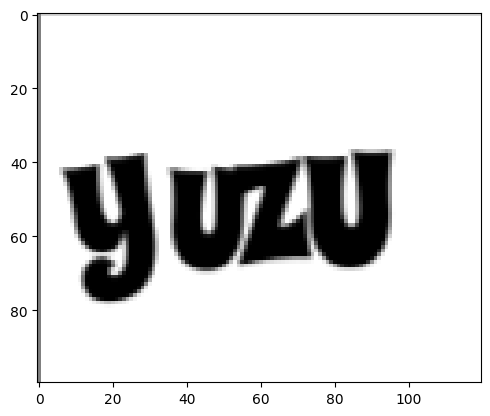

In [46]:
max_tries = 5
for _ in range(max_tries):
    clear_output(wait=True)
    with ThreadPoolExecutor() as executor:
        tasks = []
        tasks.append(executor.submit(agree_tos))
        tasks.append(executor.submit(select_quantity, no_of_tickets))
        tasks.append(executor.submit(enter_captcha))
    submit_button = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[class='btn btn-primary btn-green']")))
    plt.imshow(cv2.imread('captcha_processed.png', 0), cmap='gray')
    plt.show()

    while(True):
        try:
            submit_button.click()
            break
        except:
            continue
    try:
        WebDriverWait(driver, 10).until(EC.alert_is_present()).accept()
    except:
        break
    

In [48]:
a = 'szgvazgwse'
a.find('')

0